In [32]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from collections import defaultdict

In [33]:
def splitSampleName(x):
    """ Extract patient number, treatment, response and 
        replicate from sample name. """
    responsivePatients = [5, 126,  62]
    x = x.split('_')
    patient = int(x[1])
    treatment = x[2].split('-')[0]
    rep = x[2].split('-')[1]
    if patient in responsivePatients:
        response = 'responsive'
    else:
        response = 'resistant'
    return patient, treatment, response, rep


def defaultPlotting(size=9, width=180, ratio=0.5):
    """ Preconfigured figure settings """
    mm = 1 / 25.4 # mm in an inch
    colour = '#444444'
    sns.set(rc={
        'font.size': size, 'axes.titlesize': size, 'axes.labelsize': size,
        'xtick.labelsize': size, 'ytick.labelsize': size,
        'legend.fontsize': size, 'legend.title_fontsize': size,
        'font.family': 'sans-serif', 'lines.linewidth': 1.5,
        'axes.labelcolor': colour, 'xtick.color': colour,
        'ytick.color': colour,
        'figure.figsize': (width * mm, width * ratio * mm),
        'axes.spines.top': False, 'axes.spines.right': False,
    }, style='white')


def formatP(p):
    """ Return formatted p for title """
    if p > 0.999:
        pformat = '> 0.999'
    elif p < 0.001:
        pformat = '< .001'
    else:
        pformat = '= ' + f'{p:.3f}'[1:]
    if p < 0.001:
        return pformat + ' ***'
    elif p < 0.01:
        return pformat + ' **'
    elif p < 0.05:
        return pformat + ' *'
    else:
        return pformat

In [34]:
# Set alpha for significance threshold of q-values
alpha = 0.05

In [35]:
data = defaultdict(dict)
DEGlist = set()
for model in ['response', 'treatment']:
    # Load gene-level data
    diffGene = pd.read_csv(f'{model}/{model}-gene.csv')
    diffGene['DEG'] = diffGene['qval'] < alpha
    # Retrieve gene IDs associated with multiple gene symbols (ambiguous)
    multiMapped = diffGene.groupby('ext_gene')['target_id'].nunique() > 1
    multiMapped = multiMapped[multiMapped].index
    # Remove ambiguous gene IDs
    diffGene = diffGene.loc[~diffGene['target_id'].isin(multiMapped)]
    
    data[model]['diffGene'] = diffGene
    
    # Load transcript-level data
    diffTx = pd.read_csv(f'{model}/{model}-Tx.csv')
    diffTx['DEG'] = diffTx['qval'] < alpha
    # Remove ambiguous gene IDs
    diffTx = diffTx.loc[~diffTx['ens_gene'].isin(multiMapped)]
    data[model]['diffTx'] = diffTx
    
    # Get mean absolute logFC for each gene
    diffTx['logFC'] = np.exp(diffTx['b']).abs()
    absFC = diffTx.groupby('ens_gene')['logFC'].max()
    diffGene = pd.merge(diffGene, absFC, left_on='target_id', right_index=True)
    
    # Load count data for all conditions
    counts = pd.read_csv(f'{model}/{model}-obsNormCounts.csv')
    # Label transcript ID in count data with gene ID and gene symbol
    counts = pd.merge(
        counts, diffTx[['target_id', 'ens_gene', 'ext_gene']], 
        left_on='target_id', right_on='target_id')
    # Recover experimental group information encoded in sample name
    counts['patient'], counts['treatment'], counts['response'], counts['rep'] = (
        zip(*counts['sample'].apply(splitSampleName)))
    data[model]['counts'] = counts
    
    # Sum transcript TPM across genes
    groups = ['ens_gene', 'ext_gene', 'patient', 'treatment', 'response', 'rep']
    countsGene = counts.groupby(groups)['tpm'].sum().reset_index()
    data[model]['countsGene'] = countsGene
    
    # Get top N DEG for plotting
    n = 10
    DEGs = diffGene.loc[diffGene['DEG']].sort_values('logFC', ascending=False).head(n)['target_id'].tolist()
    DEGlist.update(DEGs)

/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


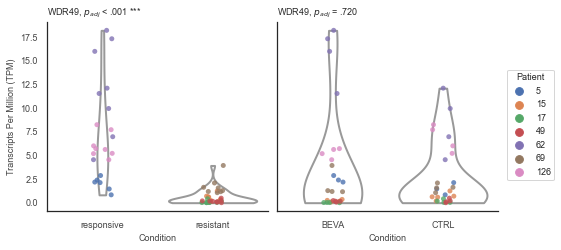

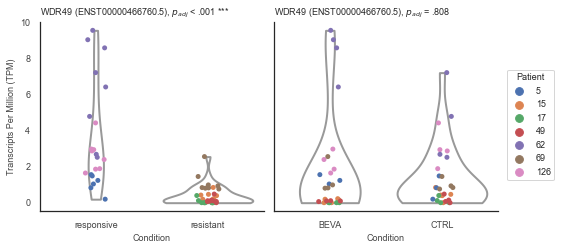

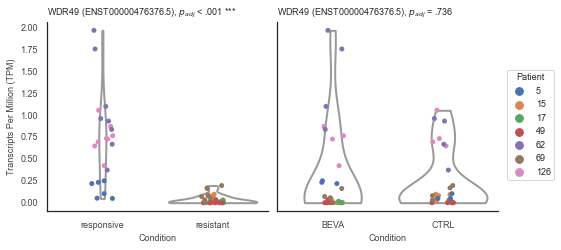

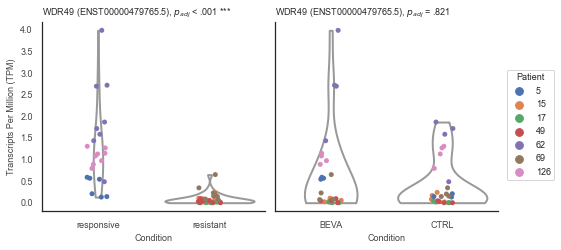

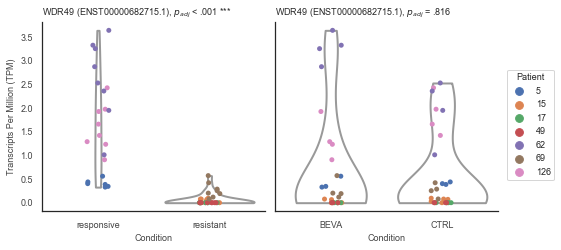

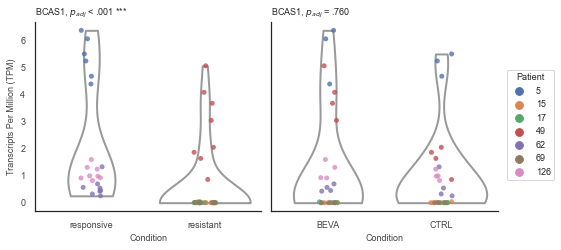

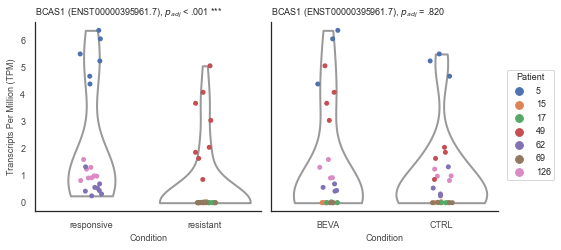

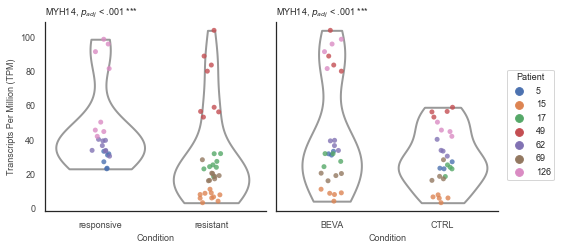

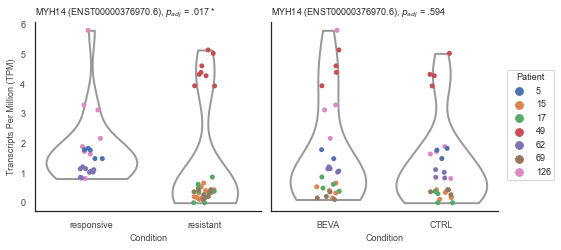

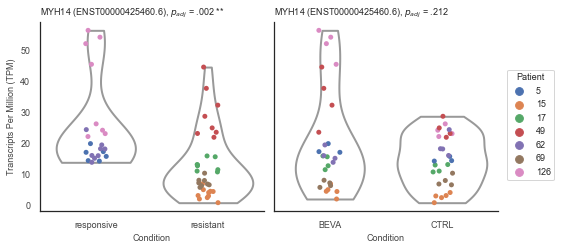

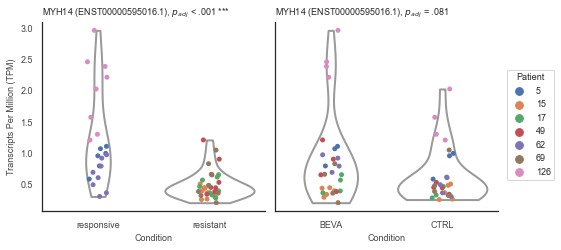

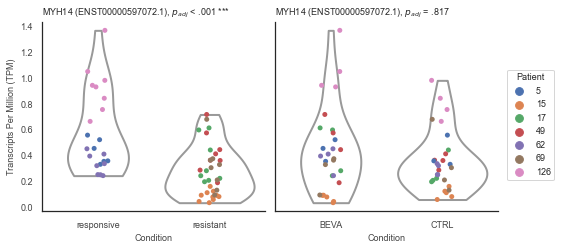

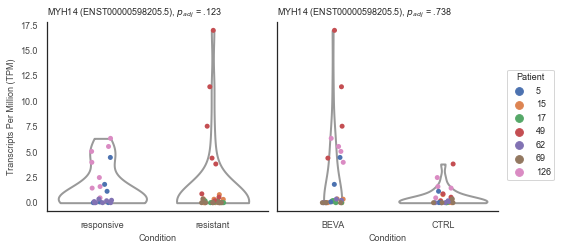

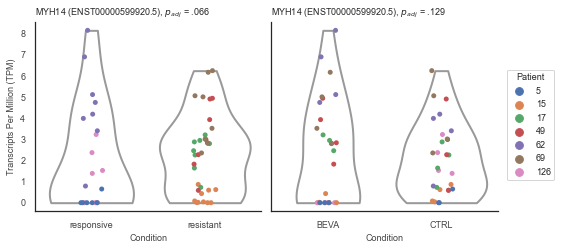

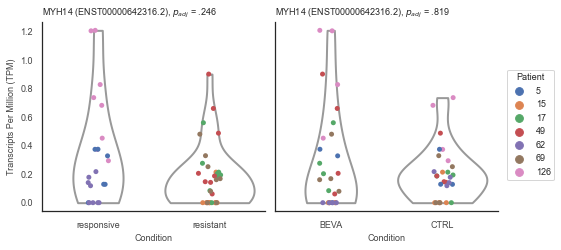

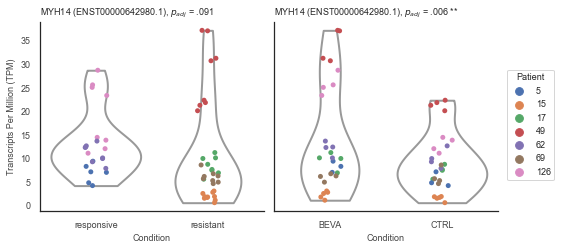

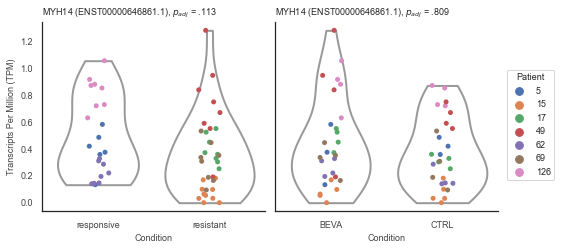

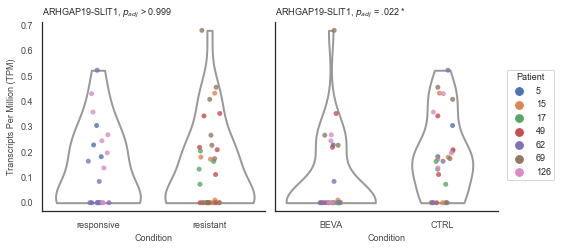

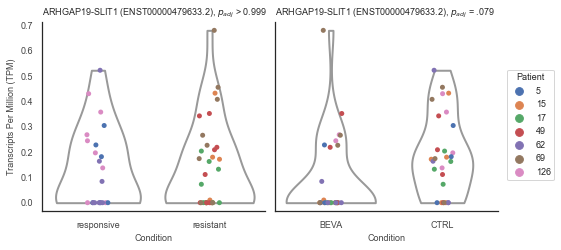

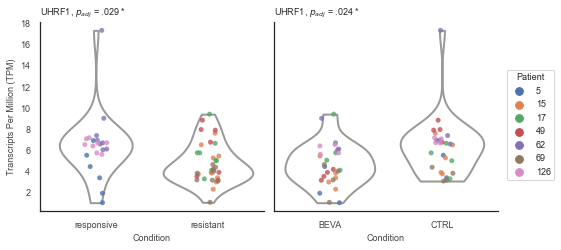

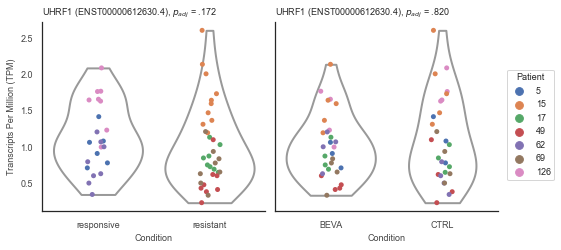

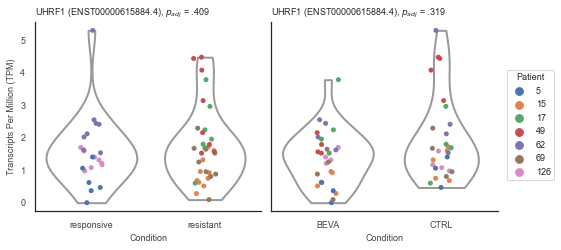

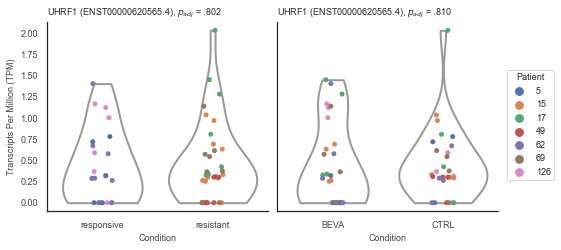

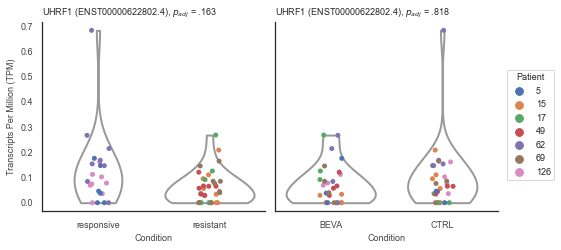

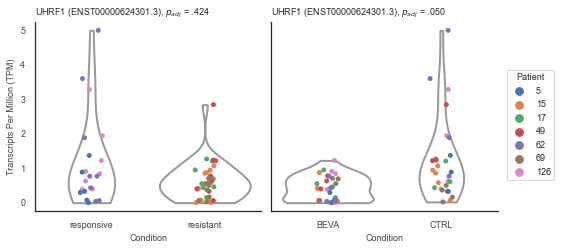

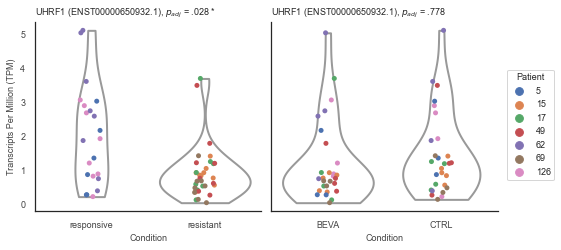

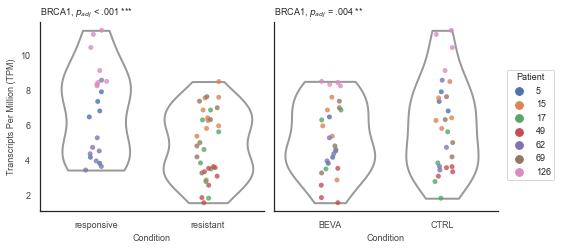

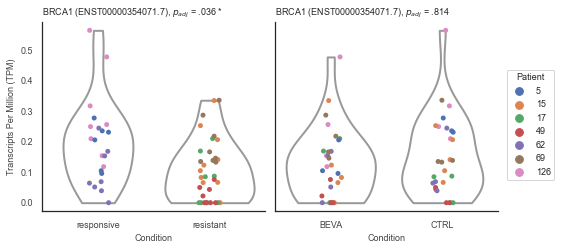

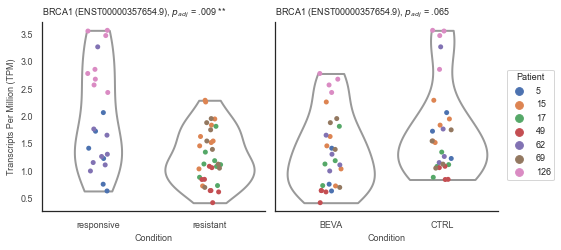

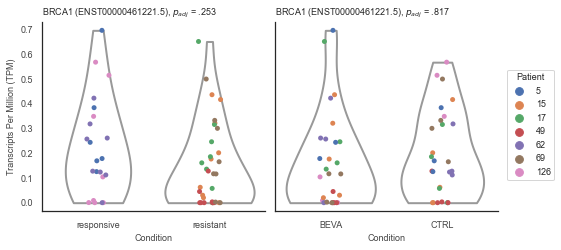

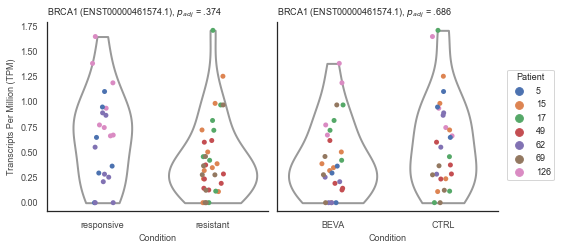

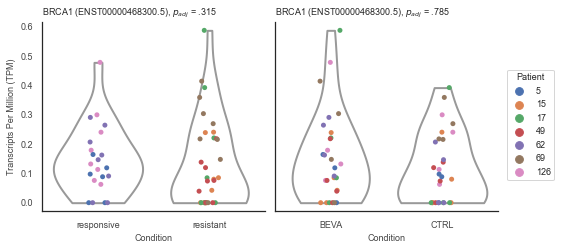

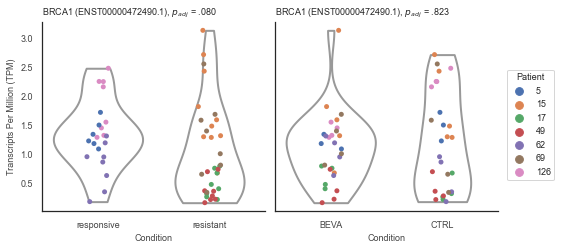

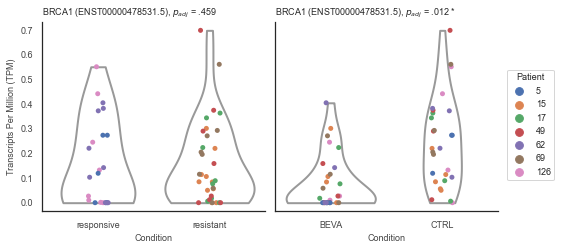

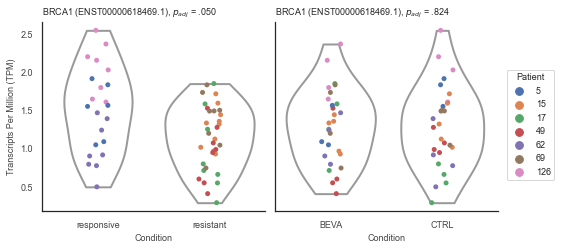

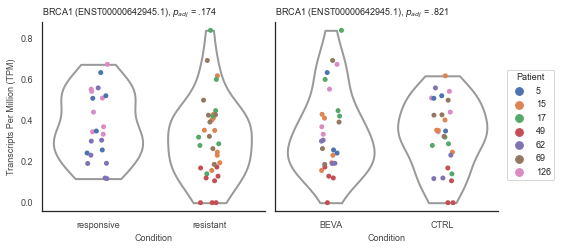

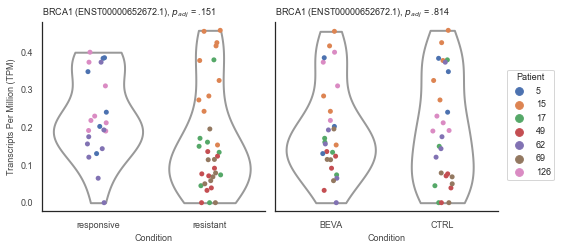

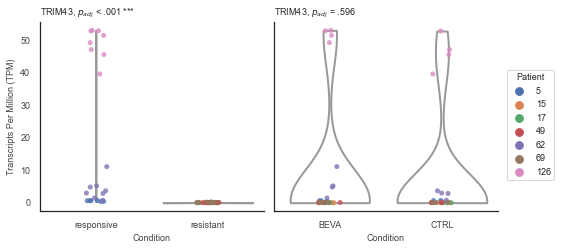

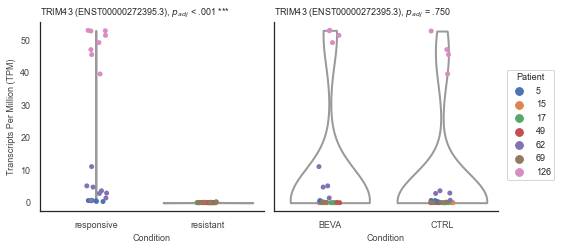

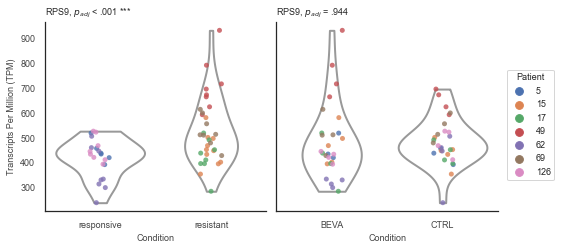

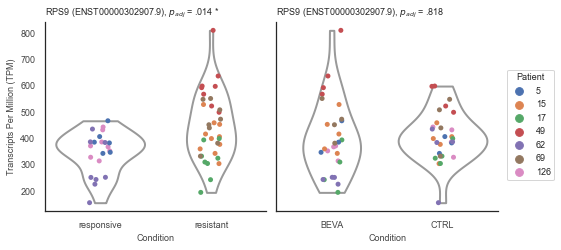

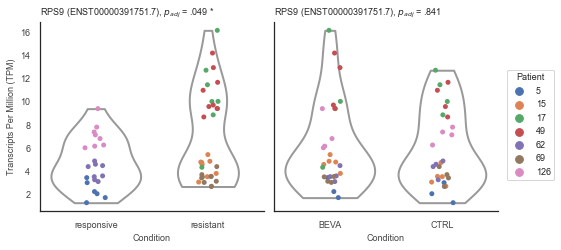

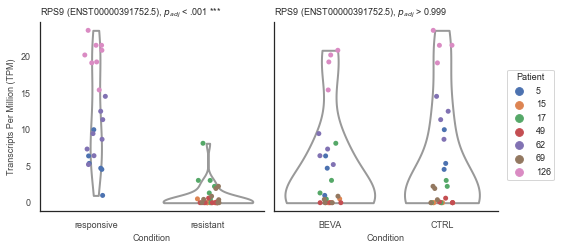

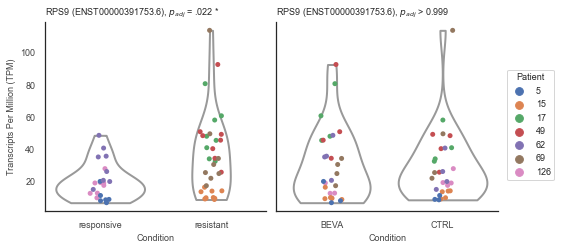

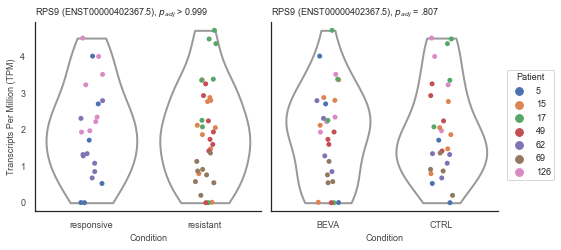

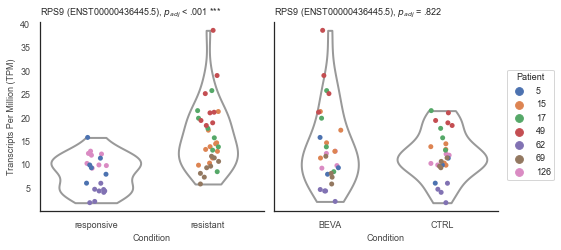

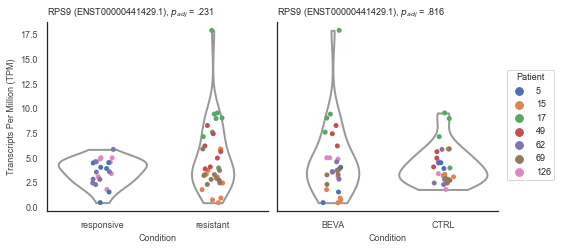

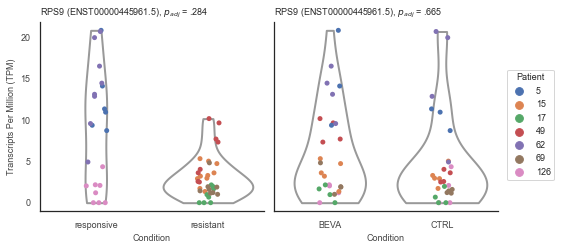

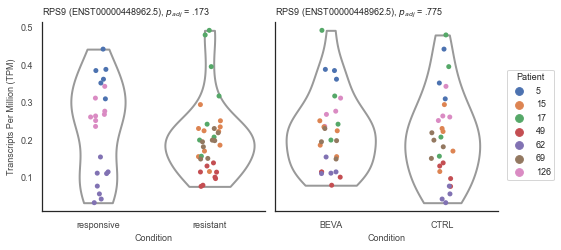

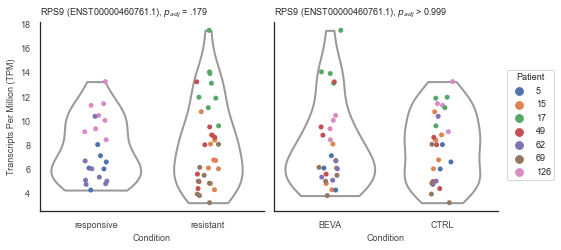

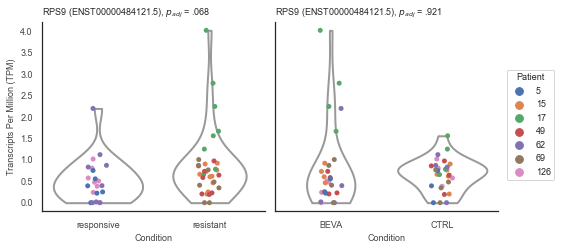

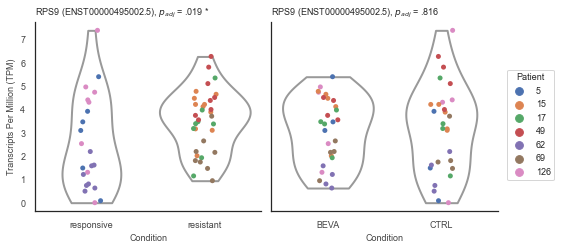

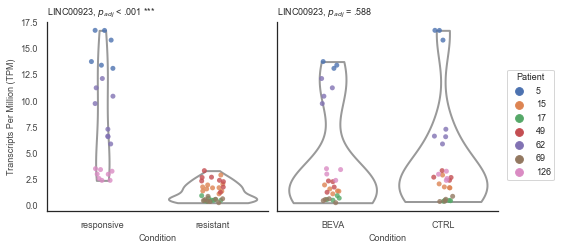

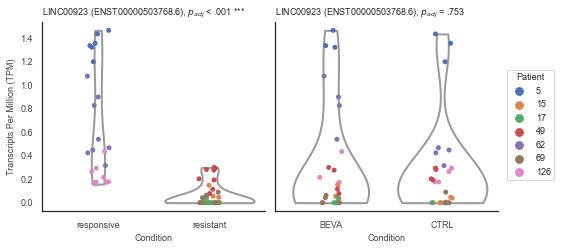

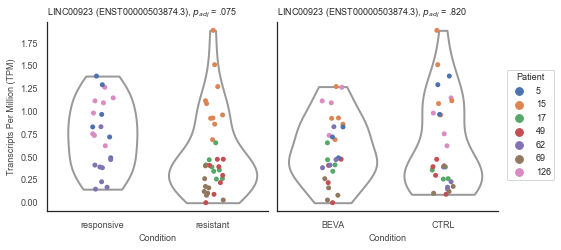

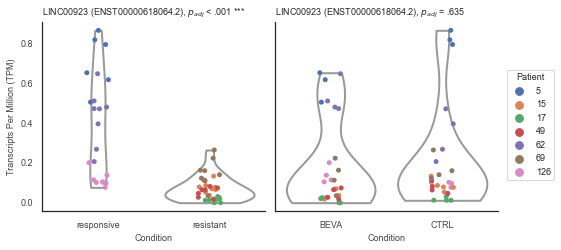

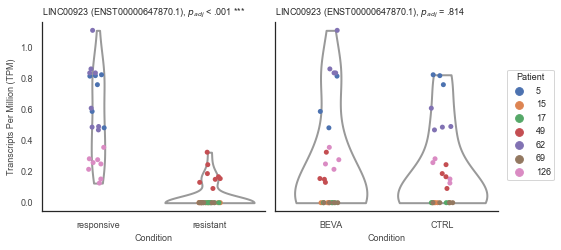

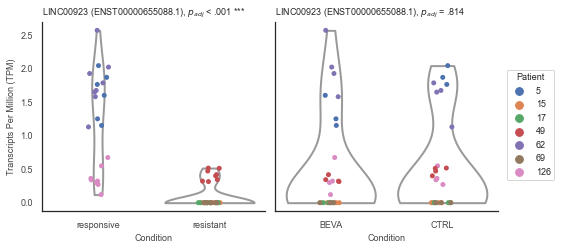

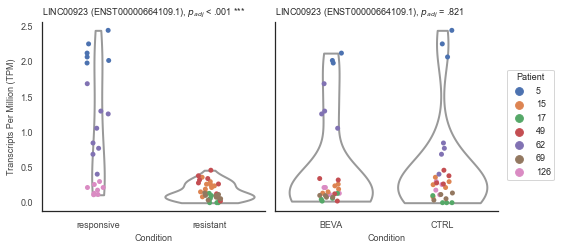

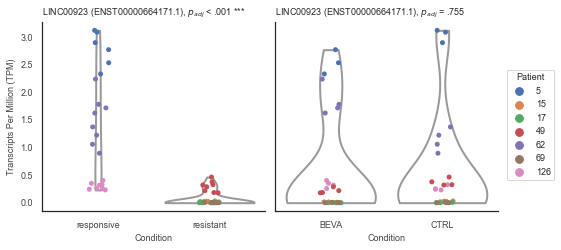

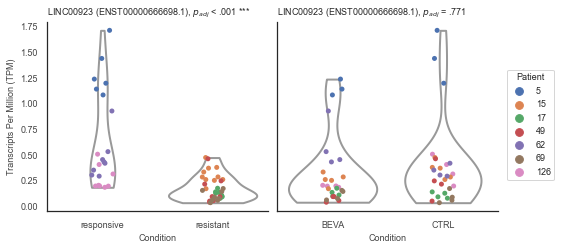

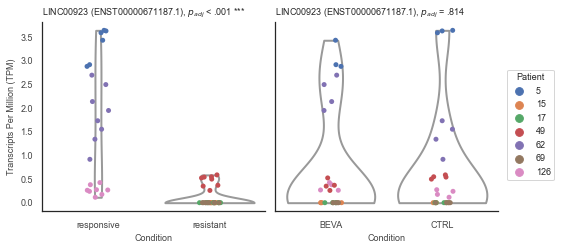

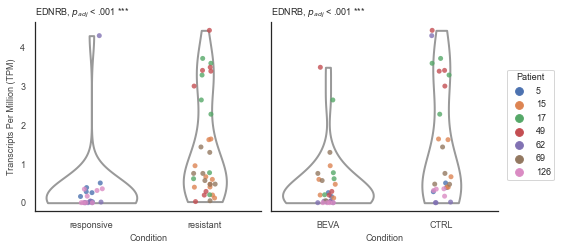

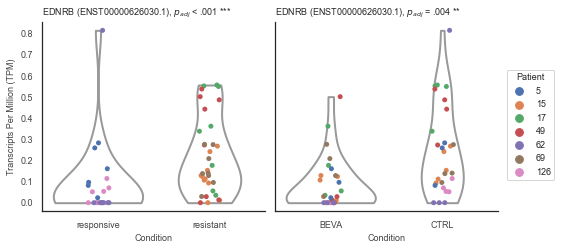

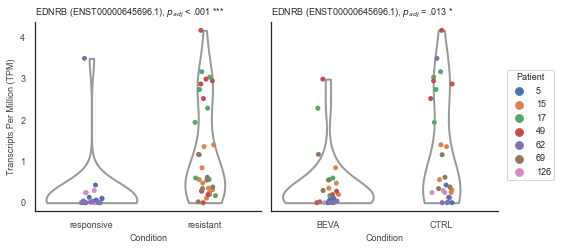

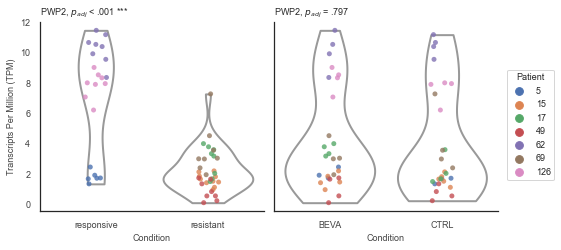

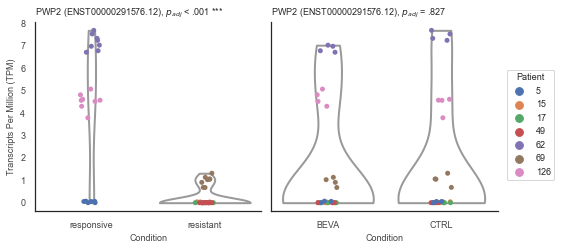

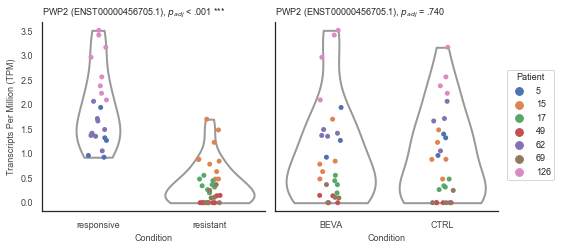

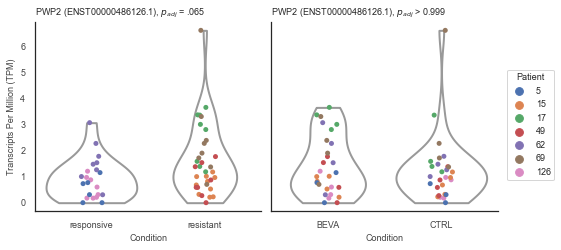

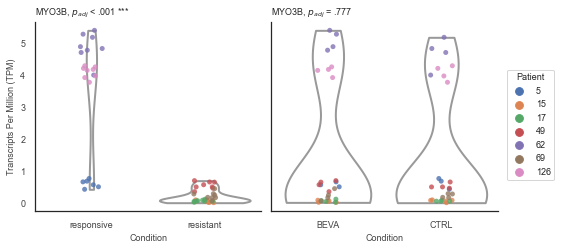

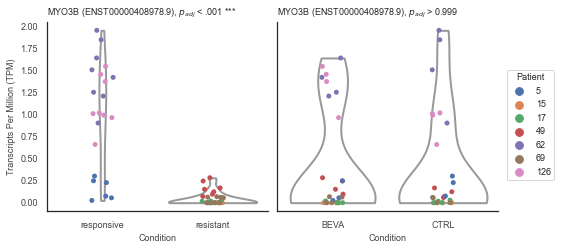

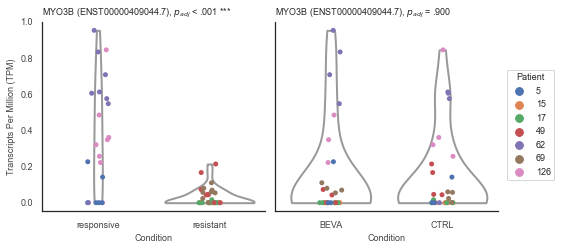

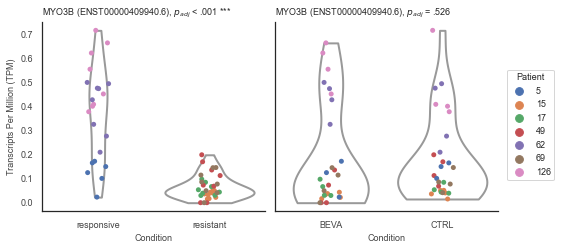

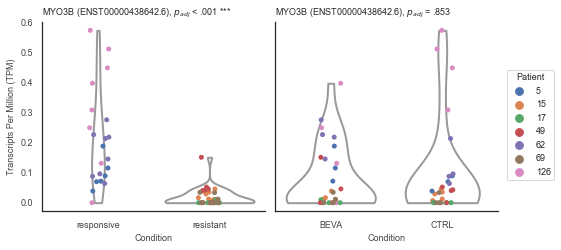

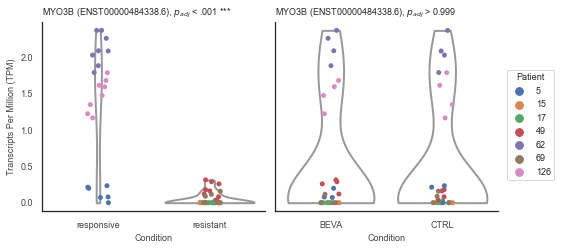

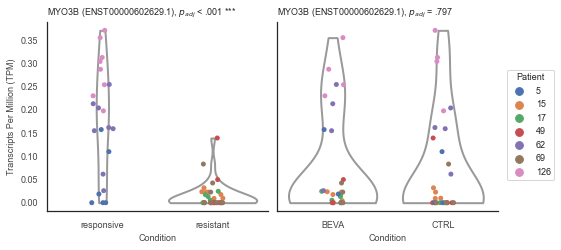

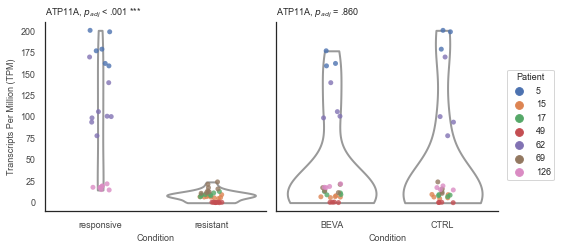

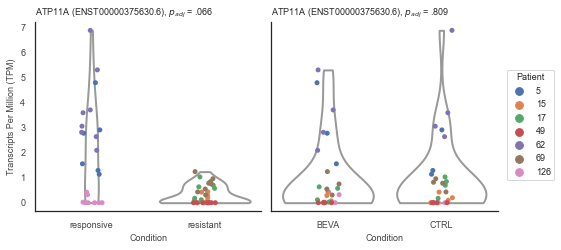

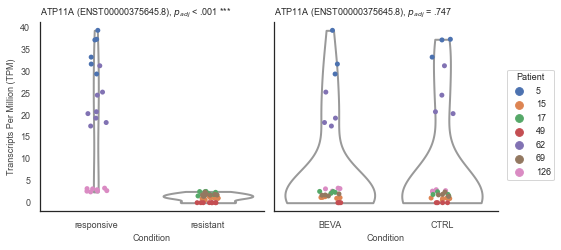

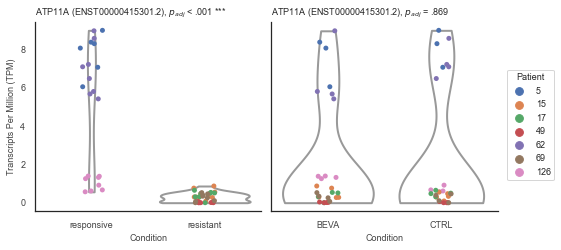

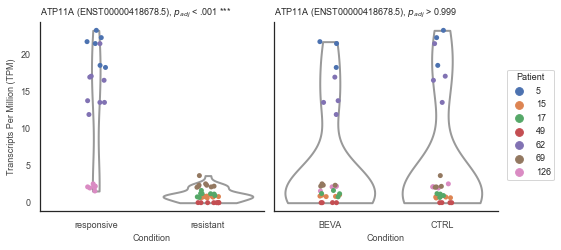

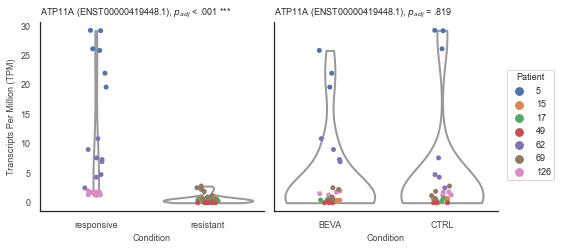

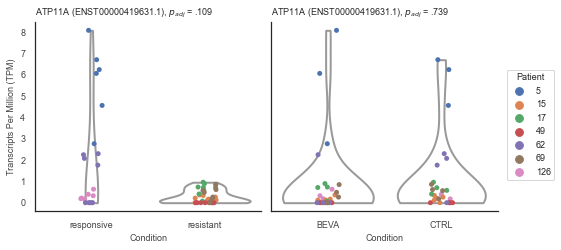

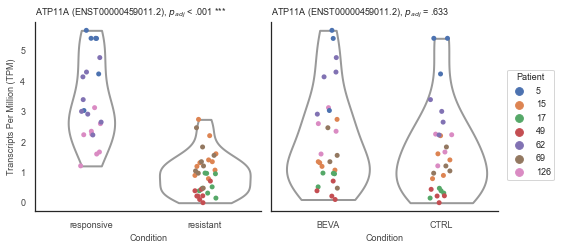

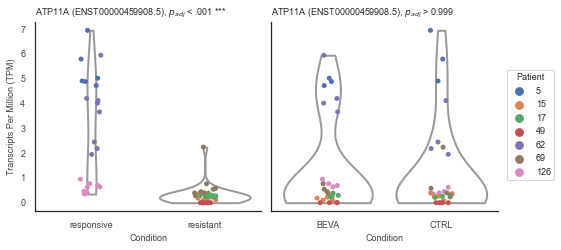

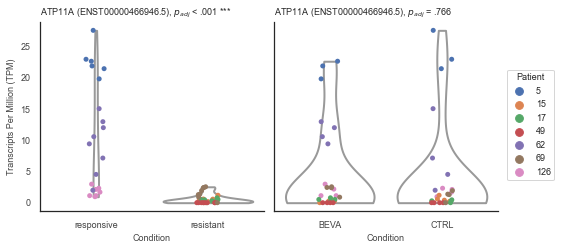

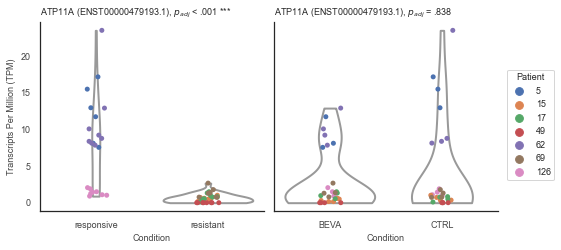

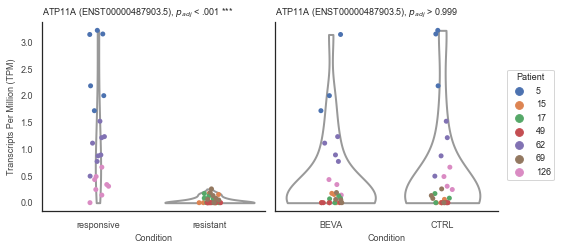

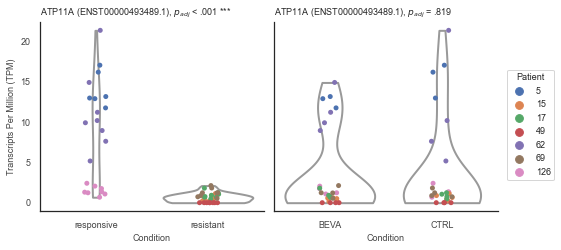

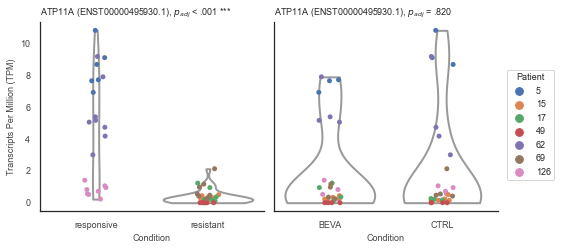

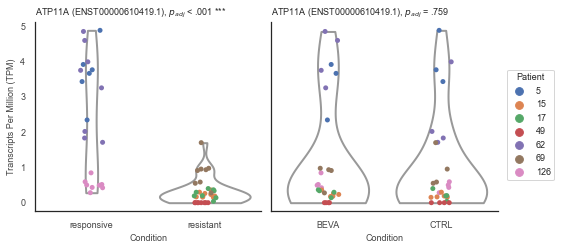

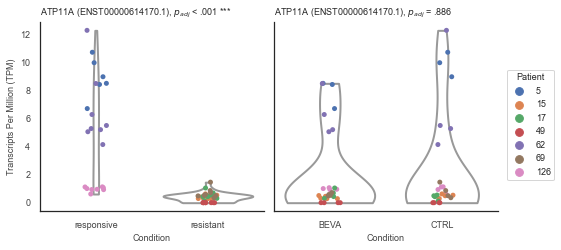

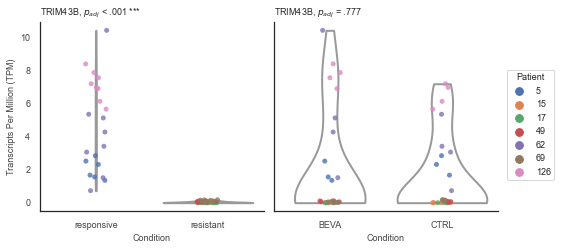

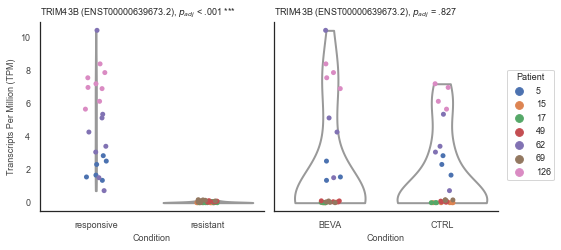

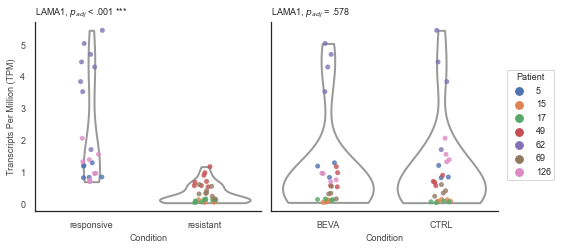

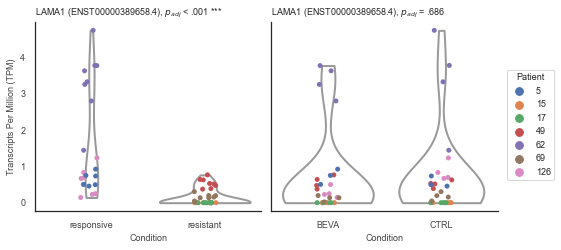

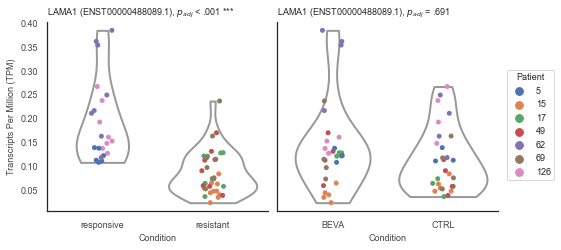

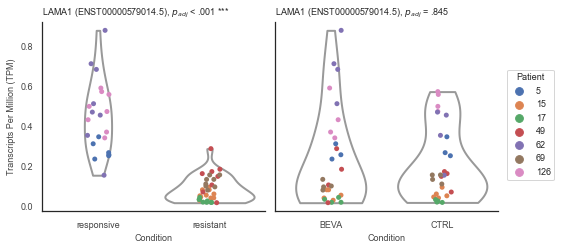

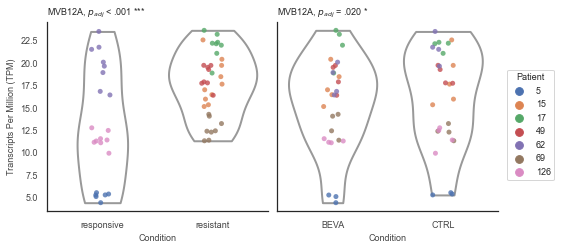

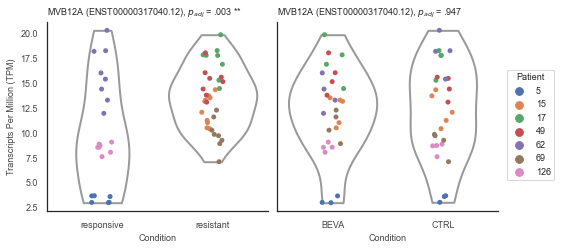

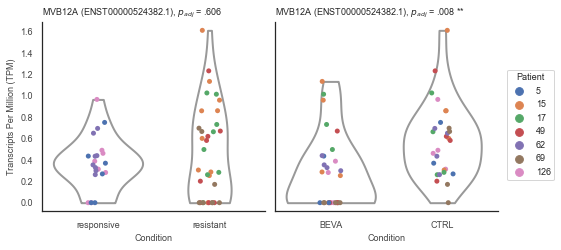

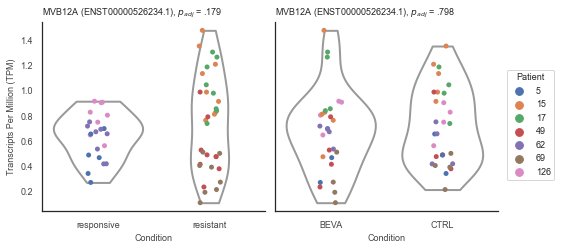

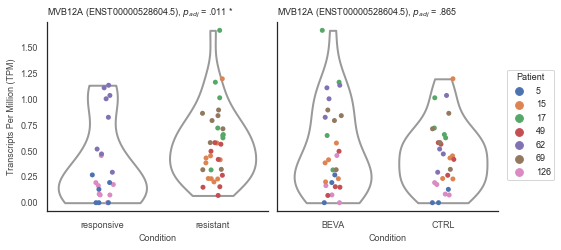

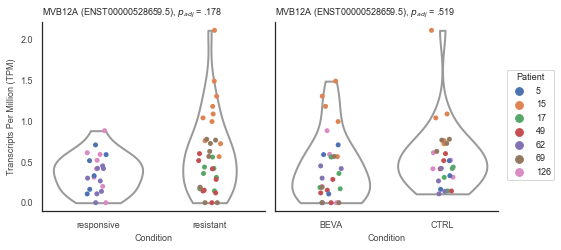

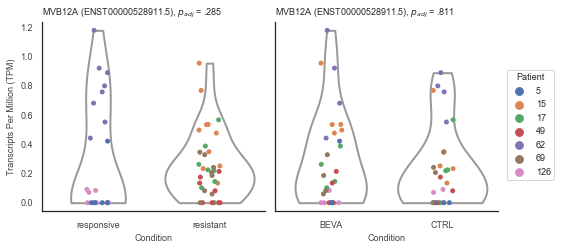

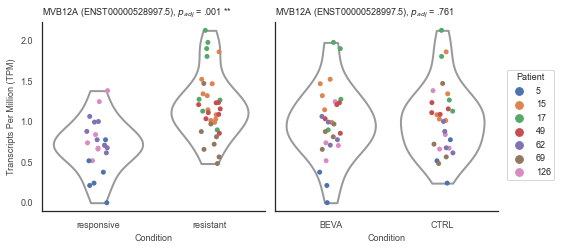

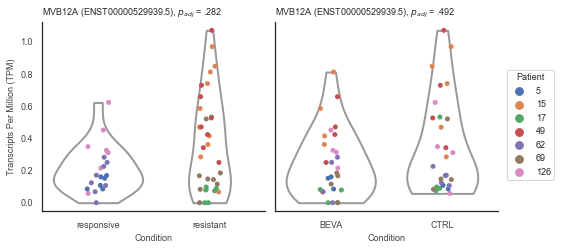

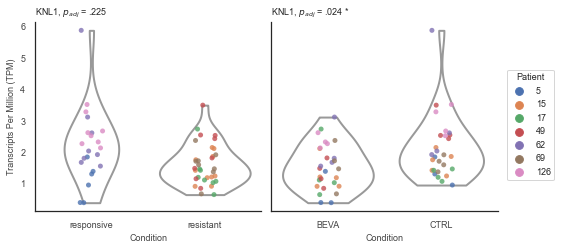

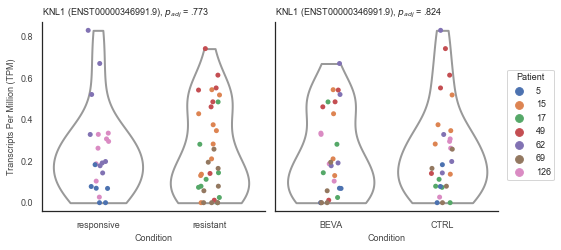

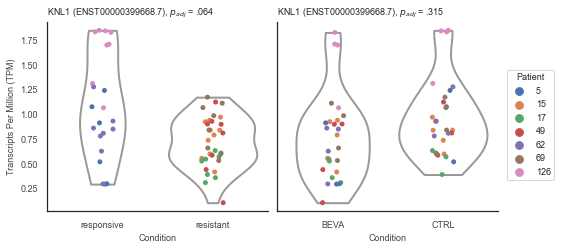

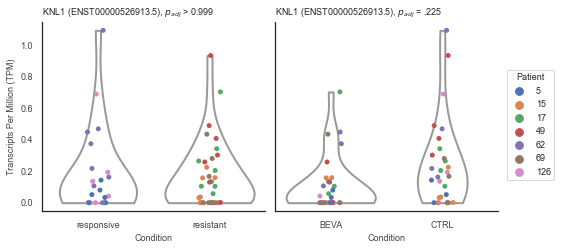

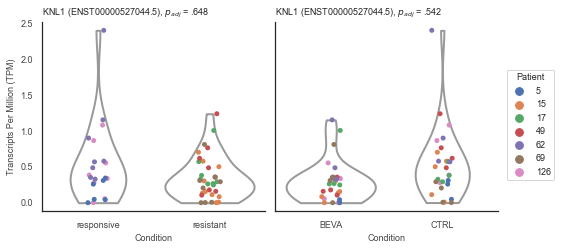

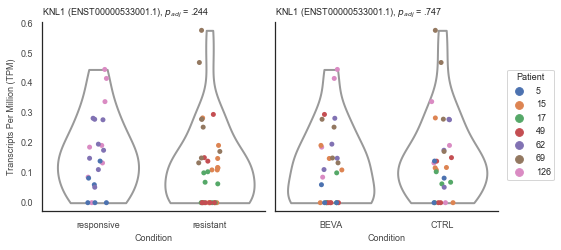

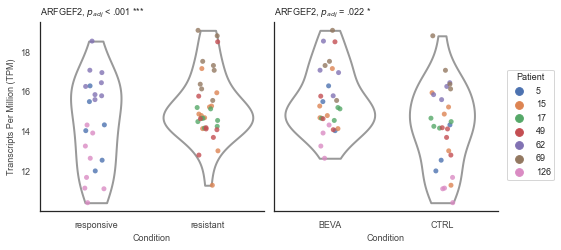

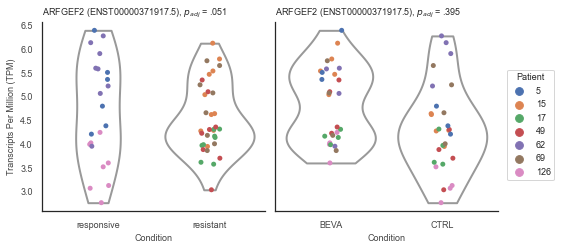

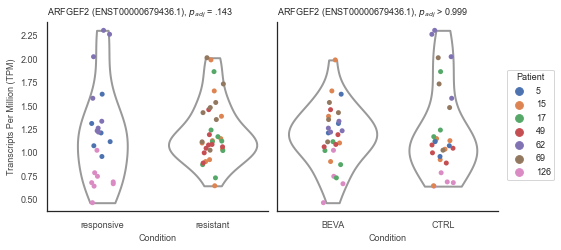

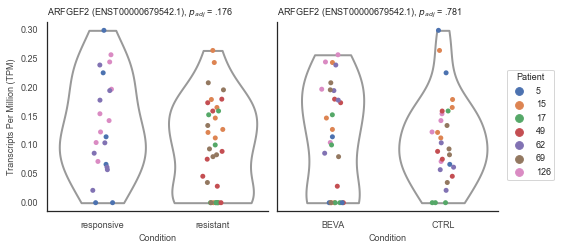

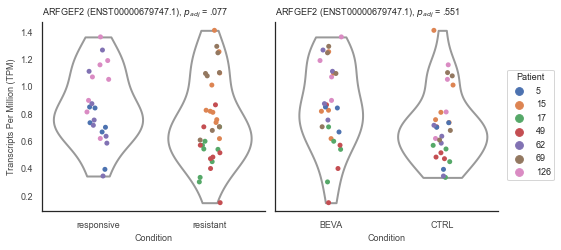

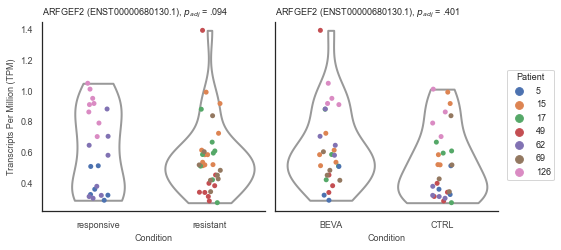

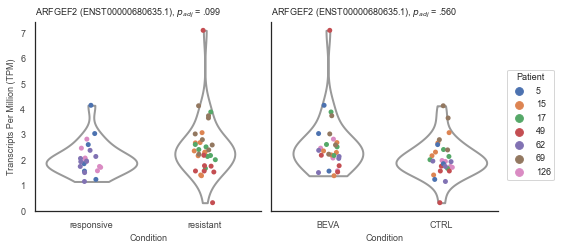

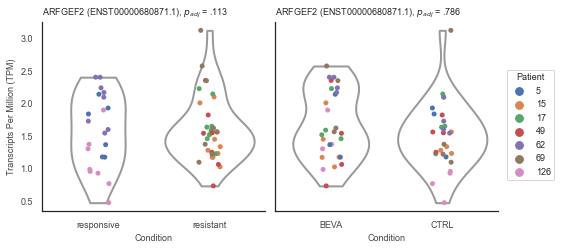

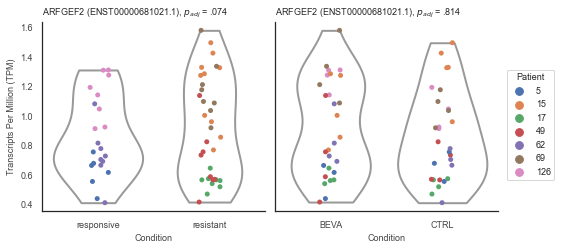

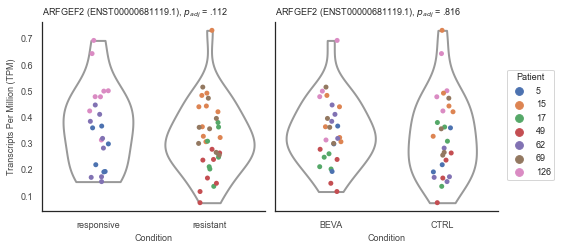

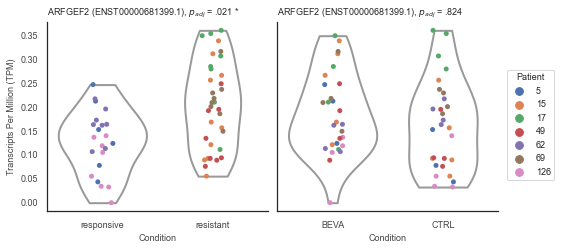

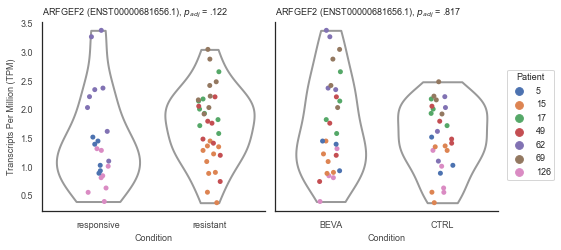

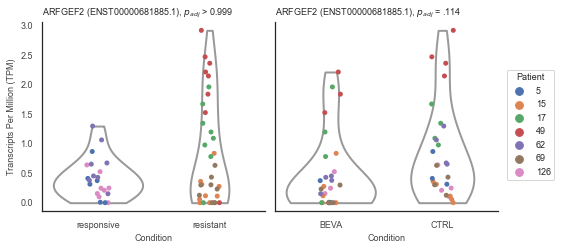

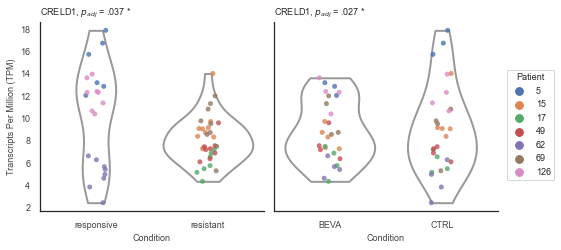

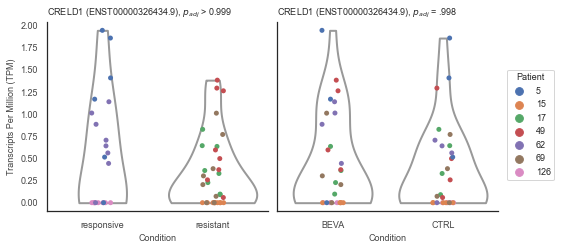

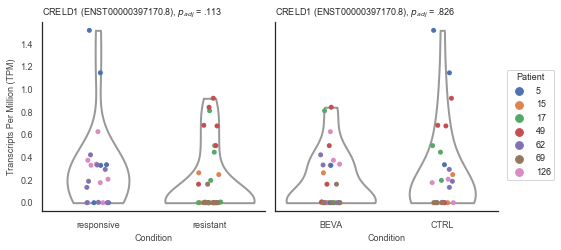

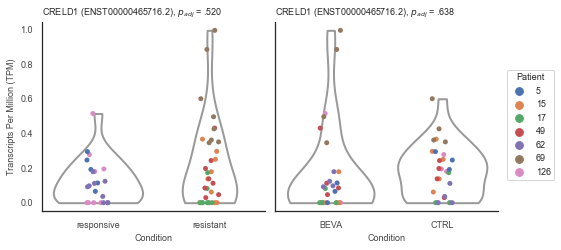

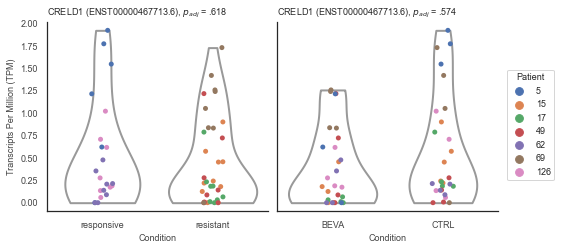

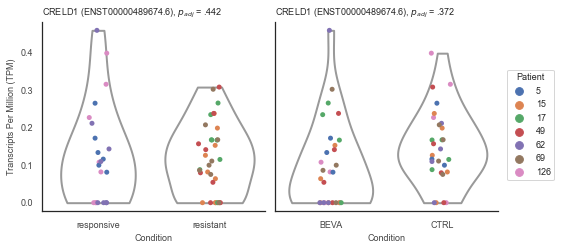

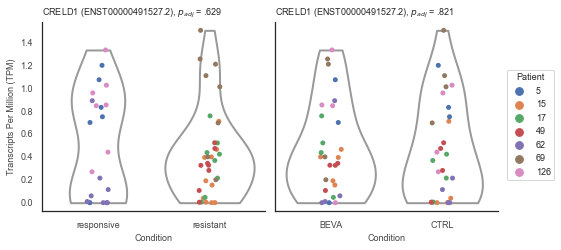

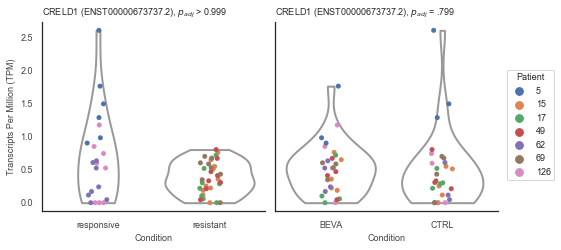

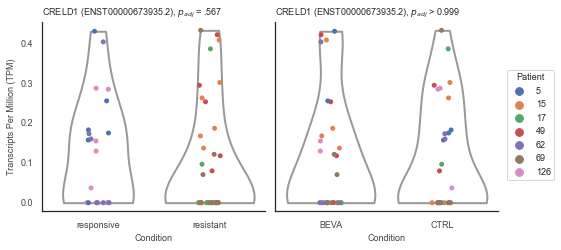

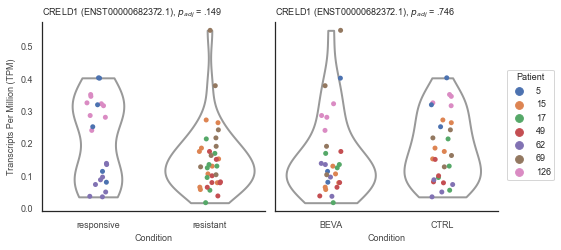

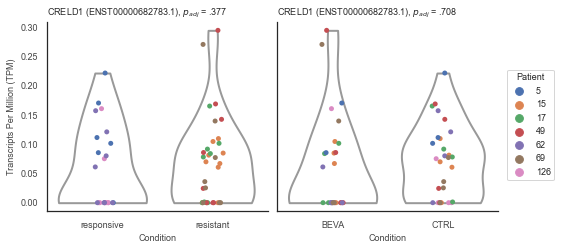

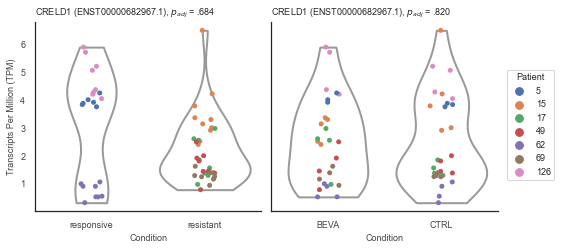

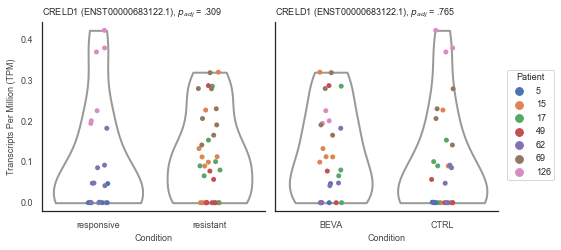

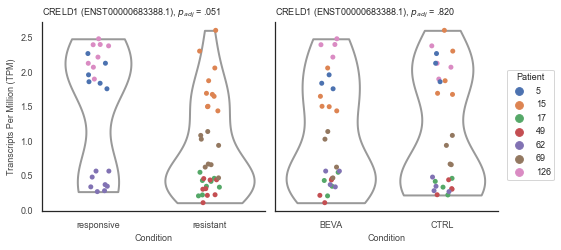

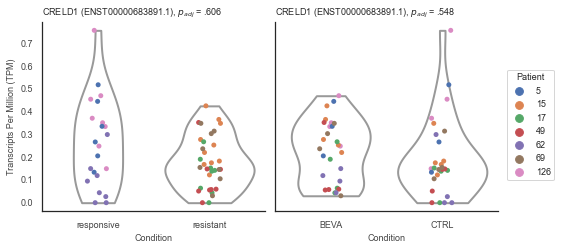

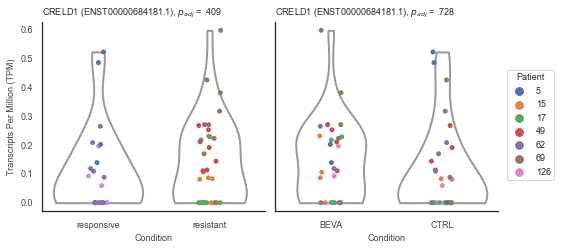

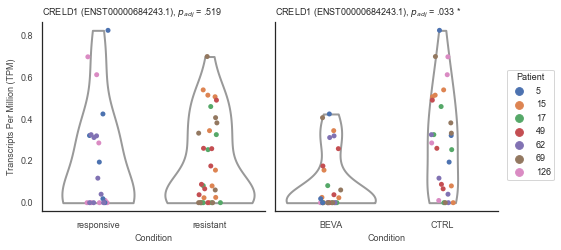

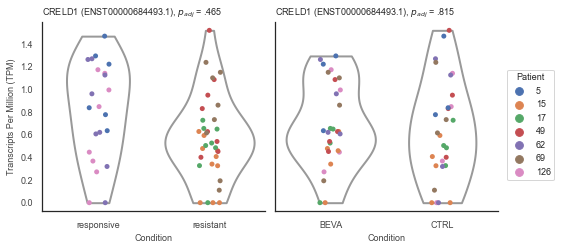

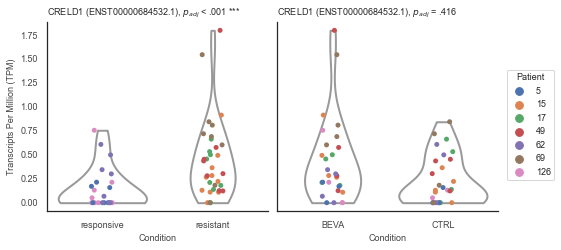

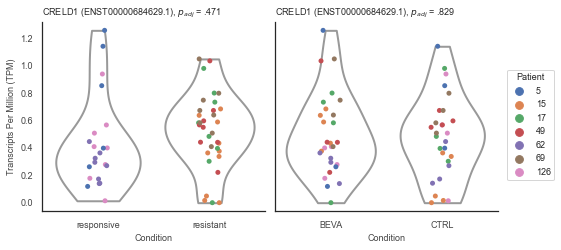

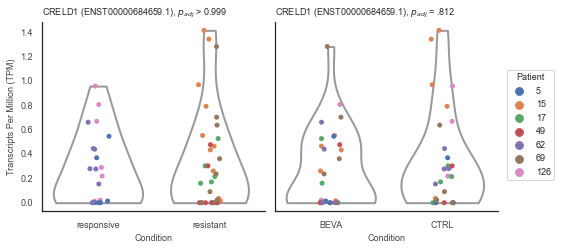

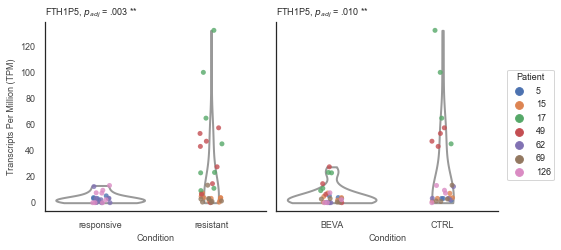

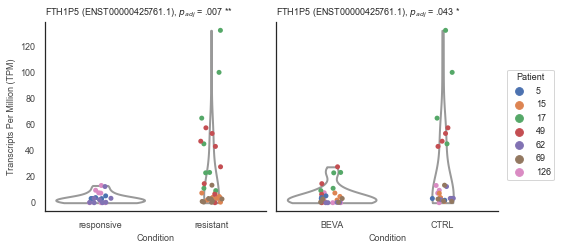

In [36]:
defaultPlotting()
for name in DEGlist:
    
    fig, axes = plt.subplots(1, 2, sharey=True)
    for i, model in enumerate(['response', 'treatment']):
        geneData = data[model]['countsGene'].loc[data[model]['countsGene']['ens_gene'] == name]
        if geneData.empty:
            axes[i].axis('off')
            continue
        p_adj = float(data[model]['diffGene'].loc[data[model]['diffGene']['target_id'] == name, 'qval'])
        symbol = data[model]['diffGene'].loc[data[model]['diffGene']['target_id'] == name, 'ext_gene'].values[0]

        sns.violinplot(
            x=model, y='tpm', inner=None, color='White',  cut=0,
            linewidth=2, data=geneData, ax=axes[i])
        sns.stripplot(
            x=model, y='tpm', hue='patient', alpha=0.8, 
            data=geneData, ax=axes[i])
        axes[i].set_xlabel('Condition')
        axes[i].set_title(f'{symbol}, $p_{{adj}}$ {formatP(p_adj)}', loc='left')
        axes[i].get_legend().remove()
    axes[0].set_ylabel('Transcripts Per Million (TPM)')
    axes[1].set_ylabel('')
    
    handles, labels = axes[1].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, loc='right', ncol=1, title='Patient', bbox_to_anchor=(1.10, 0.50))

    outName = symbol if isinstance(symbol, str) else name
    #fig.tight_layout()
    Path(f'plots/{outName}/transcripts/').mkdir(parents=True, exist_ok=True)
    fig.tight_layout()
    fig.savefig(f'plots/{outName}/{outName}-GeneLevel.svg',
                bbox_extra_artists=(lgd,), bbox_inches='tight')

    allTranscripts = data[model]['diffTx'].loc[data[model]['diffTx']['ens_gene'] == name, 'target_id'].unique()
    for i, transcript in enumerate(allTranscripts):
        fig, axes = plt.subplots(1, 2, sharey=True)
        for i, model in enumerate(['response', 'treatment']):
            countsTx = data[model]['counts'].loc[data[model]['counts']['target_id'] == transcript]
            p_adj = float(data[model]['diffTx'].loc[data[model]['diffTx']['target_id'] == transcript, 'qval'])

            sns.violinplot(
                x=model, y='tpm', inner=None, color='White', cut=0, alpha=0.8,
                linewidth=2, data=countsTx, ax=axes[i])
            sns.stripplot(
                x=model, y='tpm', hue='patient', data=countsTx, ax=axes[i])
            axes[i].set_ylabel('Transcripts Per Million (TPM)')
            axes[i].set_xlabel('Condition')
            axes[i].set_title(f'{symbol} ({transcript}), $p_{{adj}}$ {formatP(p_adj)}', loc='left')
            axes[i].get_legend().remove()
        axes[0].set_ylabel('Transcripts Per Million (TPM)')
        axes[1].set_ylabel('')

        handles, labels = axes[1].get_legend_handles_labels()
        lgd = fig.legend(handles, labels, loc='right', ncol=1, title='Patient', bbox_to_anchor=(1.10, 0.50))
        fig.tight_layout()
        fig.savefig(f'plots/{outName}/transcripts/{transcript}.svg',
                    bbox_extra_artists=(lgd,), bbox_inches='tight')


In [79]:
outName

'ABCB9'